# Goal

The goal here is to write everything with modular code and then conduct experiments that allow us to get ECN networks to work properly on the CityScapes dataset. We will try a few different approaches to improve results:

* Try different architectures, including a two-stage approach, as well as trying to predict residuals rather than the original $y$ labels
* Increasing the receptive field size on the input as well as the output


# Setup

In [81]:
import os
import matplotlib.pyplot as plt
import argparse
import numpy as np

from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import Input, Embedding, LSTM, Dense, Conv2D, Flatten, Reshape, Add, Concatenate, MaxPool2D
from keras.models import Model, Sequential, load_model
from keras.optimizers import Adam
from keras import backend as K

from model.unet import unet, unet_small, dice_coef
from model.fcn import fcn_8s
from model.pspnet import pspnet50
from dataset_parser import generator_coarse, generator

from scripts import *

%load_ext autoreload
%autoreload 2

print('GPUs available:', K.tensorflow_backend._get_available_gpus())

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
GPUs available: ['/job:localhost/replica:0/task:0/device:GPU:0']


# Train a Model on Coarse Data

In [9]:
TRAIN_BATCH = int(4)
VAL_BATCH = int(4)
lr_init = 1e-4
lr_decay = 5e-4
vgg_path = None
model_name = "modular_unet_coarse_weights.h5"
TRAIN_N = 2975
VAL_N = 500

labels = ['background', 'car', 'road']  # Use only 3 classes.
ignore_pedestrians=not('person' in labels)

coarse_model = unet(input_shape=(256, 512, 3), num_classes=len(labels),
                    lr_init=lr_init, lr_decay=lr_decay, vgg_weight_path=vgg_path)

In [11]:
checkpoint = ModelCheckpoint(filepath=model_name,
                             monitor='val_dice_coef',
                             save_best_only=True,
                             save_weights_only=True)

In [12]:
history = coarse_model.fit_generator(generator_coarse.data_generator('dataset_parser/data-coarse.h5', TRAIN_BATCH, 'train_extra', ignore_pedestrians=ignore_pedestrians),
                                     steps_per_epoch= TRAIN_N // TRAIN_BATCH,
                                     validation_data=generator.data_generator('dataset_parser/data.h5', VAL_BATCH, 'val', ignore_pedestrians=ignore_pedestrians),
                                     validation_steps=VAL_N // VAL_BATCH,
                                     callbacks=[checkpoint],
                                     epochs=5, verbose=1)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/5
5005000

500
743/743 [==============================] - 250s 337ms/step - loss: 0.2192 - dice_coef: 0.8727 - val_loss: 0.4621 - val_dice_coef: 0.8078
Epoch 2/5
743/743 [==============================] - 248s 333ms/step - loss: 0.1477 - dice_coef: 0.9129 - val_loss: 0.3854 - val_dice_coef: 0.8506
Epoch 3/5
743/743 [==============================] - 248s 333ms/step - loss: 0.1638 - dice_coef: 0.9046 - val_loss: 0.2980 - val_dice_coef: 0.8586
Epoch 4/5
743/743 [==============================] - 248s 333ms/step - loss: 0.1213 - dice_coef: 0.9295 - val_loss: 0.2855 - val_dice_coef: 0.8770
Epoch 5/5
743/743 [==============================] - 247s 332ms/step - loss: 0.1317 - dice_coef: 0.9230 - val_loss: 0.3026 - val_dice_coef: 0.8722


In [7]:
fine_model = unet(input_shape=(256, 512, 3), num_classes=len(labels),
                  lr_init=lr_init, lr_decay=lr_decay, vgg_weight_path=vgg_path)

fine_generator = generator.data_generator('dataset_parser/data.h5', TRAIN_BATCH, 'train', 
                                          ignore_pedestrians=ignore_pedestrians)

history = fine_model.fit_generator(fine_generator,
                                   steps_per_epoch= 500 // TRAIN_BATCH,
                                   validation_data=generator.data_generator('dataset_parser/data.h5', VAL_BATCH, 'val', ignore_pedestrians=ignore_pedestrians),
                                   validation_steps=VAL_N // VAL_BATCH,
                                   callbacks=[checkpoint],
                                   epochs=5, verbose=1)

Epoch 1/5
5002975
2975

500
125/125 [==============================] - 58s 467ms/step - loss: 0.5090 - dice_coef: 0.6938 - val_loss: 0.5481 - val_dice_coef: 0.7521
Epoch 2/5
125/125 [==============================] - 53s 422ms/step - loss: 0.3181 - dice_coef: 0.8088 - val_loss: 0.5483 - val_dice_coef: 0.7626
Epoch 3/5
125/125 [==============================] - 53s 426ms/step - loss: 0.2856 - dice_coef: 0.8347 - val_loss: 0.6646 - val_dice_coef: 0.7117
Epoch 4/5
125/125 [==============================] - 53s 428ms/step - loss: 0.2564 - dice_coef: 0.8509 - val_loss: 0.3315 - val_dice_coef: 0.8415
Epoch 5/5
125/125 [==============================] - 53s 427ms/step - loss: 0.2333 - dice_coef: 0.8678 - val_loss: 0.4474 - val_dice_coef: 0.8169


# View Predictions

Manually view them to confirm that the predictions on the training set are similar to the training labels

2975
2975
2975


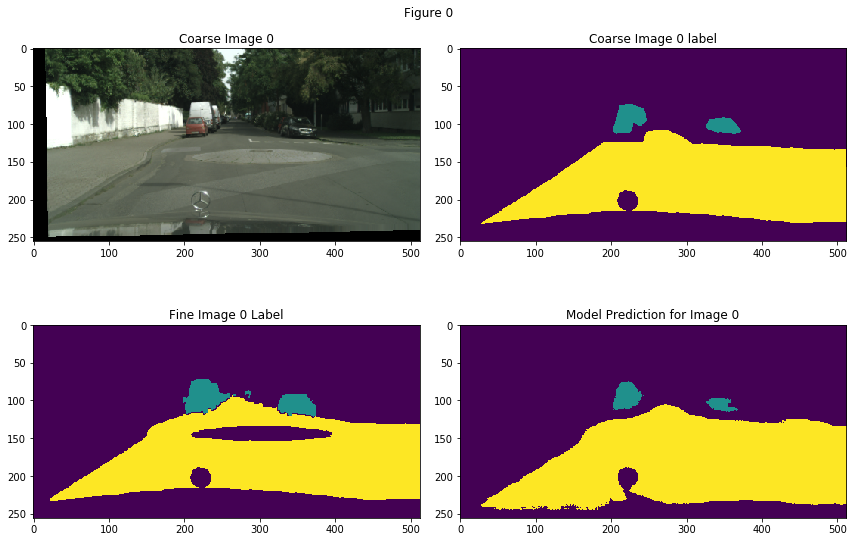

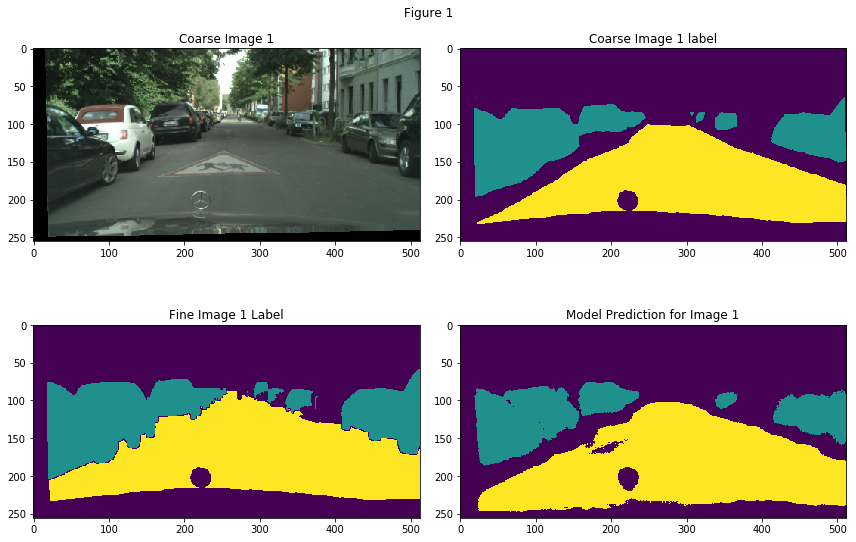

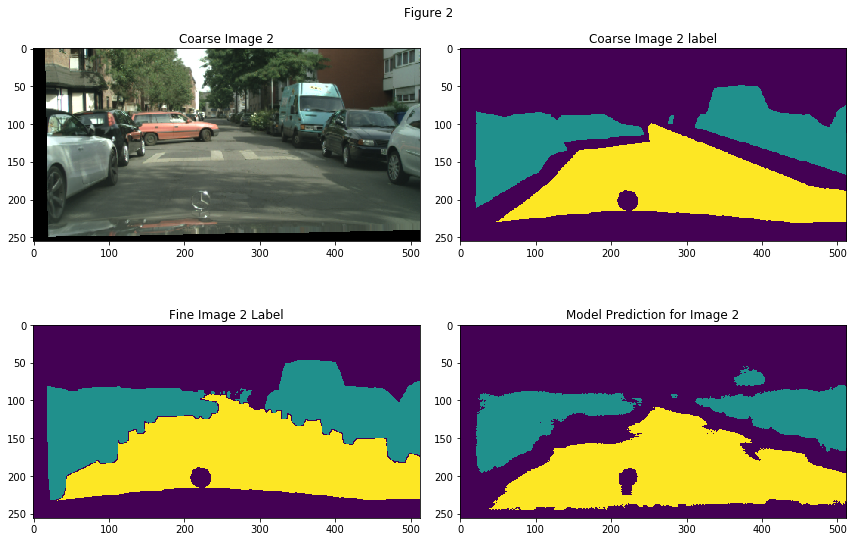

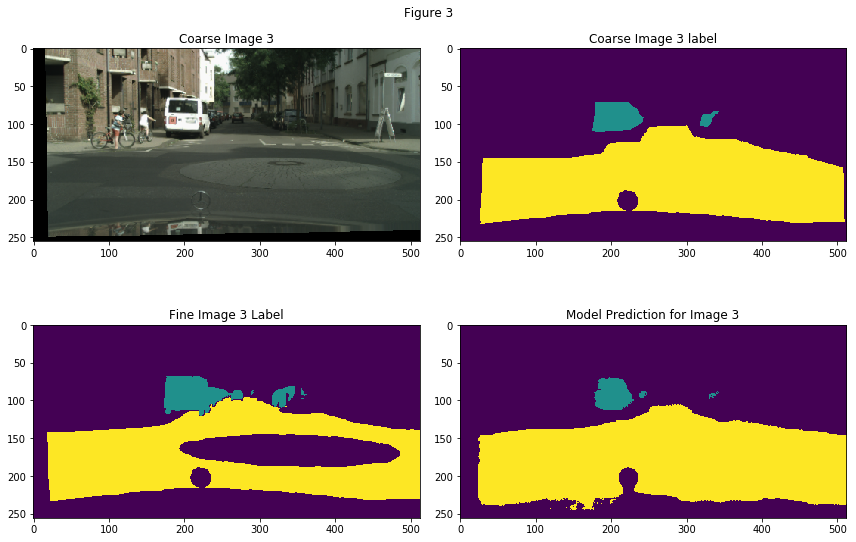

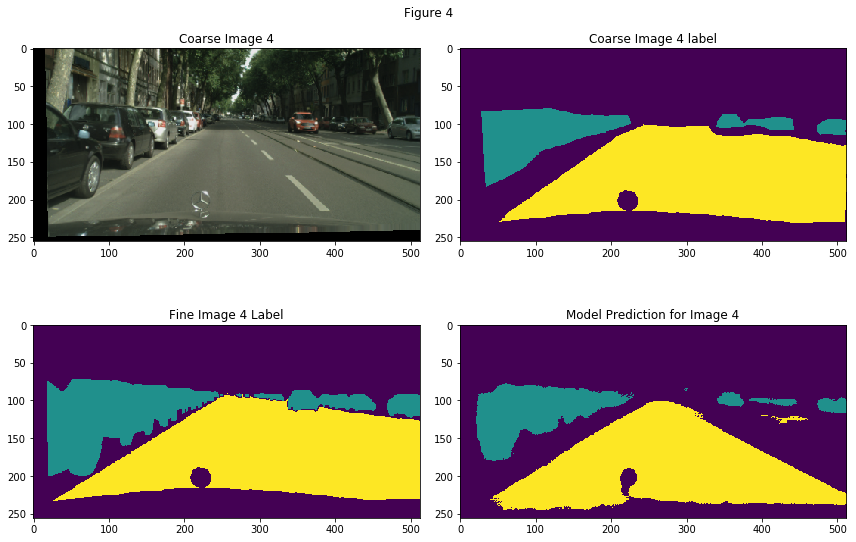

In [13]:
view_paired_predictions_on_training_data(coarse_model, ignore_pedestrians=ignore_pedestrians)

# Get Error-Correcting Model

In [218]:
from keras.layers import Input, Embedding, LSTM, Dense, Conv2D, Flatten, Reshape, Add, Concatenate, MaxPool2D, Lambda
from keras.models import Model, Sequential, load_model
from keras.optimizers import Adam
from keras import backend as K

input_window_size = 64
output_window_size = 1

# ec_model = get_ec_model(input_window_size, output_window_size, dice_coef=dice_coef)

lr_init = 1e-3
lr_decay = 5e-4

inp_y = Input(shape=(input_window_size, input_window_size, 3))
inp_x = Input(shape=(input_window_size, input_window_size, 3))

h = Concatenate()([inp_x, inp_y])
h = Conv2D(8, (4, 4), padding='same', activation='relu')(h)
h = MaxPool2D((2, 2), padding='same')(h)
h = Conv2D(8, (4, 4), padding='same', activation='relu')(h)
h = MaxPool2D((2, 2), padding='same')(h)
h = Conv2D(16, (4, 4), padding='same', activation='relu')(h)
h = Flatten()(h)
h = Dense(40, activation='relu')(h)
h = Dense(3, activation='softmax')(h)
h = Reshape((1, 1, 3))(h)
ec_model = Model(inputs=[inp_x, inp_y], outputs=h)

# h = Concatenate()([inp_x, inp_y])
# h = Conv2D(8, (4, 4), padding='same', activation='relu')(h)
# h = MaxPool2D((2, 2), padding='same')(h)
# h = Conv2D(8, (4, 4), padding='same', activation='relu')(h)
# h = MaxPool2D((2, 2), padding='same')(h)
# h = Conv2D(16, (4, 4), padding='same', activation='relu')(h)
# h = Flatten()(h)
# h = Dense(40, activation='relu')(h)
# h = Dense(3, activation='softmax')(h)
# h = Reshape((1, 1, 3))(h)
# ec_model = Model(inputs=[inp_x, inp_y], outputs=h)

# h = Concatenate()([inp_y, inp_x])
# h = Conv2D(8, (4, 4), padding='same', activation='relu')(inp_y)
# h = MaxPool2D((2, 2), padding='same')(h)
# h = Conv2D(8, (4, 4), padding='same', activation='relu')(h)
# h = MaxPool2D((2, 2), padding='same')(h)
# h = Flatten()(h)
# h = Dense(3, activation='softmax')(h)
# h = Reshape((1, 1, 3))(h)
# ec_model = Model(inputs=inp_y, outputs=h)

ec_model.summary()
metrics=['mean_squared_error', dice_coef]
ec_model.compile(optimizer=Adam(lr=lr_init, decay=lr_decay),
                 loss='categorical_crossentropy', metrics=metrics)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_71 (InputLayer)           (None, 64, 64, 3)    0                                            
__________________________________________________________________________________________________
input_70 (InputLayer)           (None, 64, 64, 3)    0                                            
__________________________________________________________________________________________________
concatenate_44 (Concatenate)    (None, 64, 64, 6)    0           input_71[0][0]                   
                                                                 input_70[0][0]                   
__________________________________________________________________________________________________
conv2d_114 (Conv2D)             (None, 64, 64, 8)    776         concatenate_44[0][0]             
__________

# Train EC Model 

In [75]:
test_get_ec_batch()

Test 1 passed
Test 2 passed
Test 3 passed


In [219]:
n_epochs = 20
batch_size = 8
skip = 12
N_CLEAN = 500
best_val = 0

val_generator = generator.data_generator('dataset_parser/data.h5', 32, 'val', ignore_pedestrians=True)

x_val, y_val = next(val_generator)
y_val_coarse = coarse_model.predict(x_val)
x_val_batch, y_val_coarse_batch, y_val_diff_batch = get_ec_batch(
    x_val, y_val, y_val_coarse, input_window_size=input_window_size,
    output_window_size=output_window_size, skip=skip, diff=False)

for e in range(n_epochs):
    fine_generator = generator.data_generator('dataset_parser/data.h5', batch_size, 'train', 
                                              ignore_pedestrians=ignore_pedestrians)
    for i in range(N_CLEAN // batch_size):
        x, y_fine = next(fine_generator)
        y_coarse = coarse_model.predict(x)
        x_batch, y_coarse_batch, y_diff_batch = get_ec_batch(x, y_fine, y_coarse, input_window_size=input_window_size,
                                                             output_window_size=output_window_size, skip=skip, diff=False,
                                                             balanced=True)
        
#         metrics = ec_model.train_on_batch(y_coarse_batch, y_diff_batch)
        metrics = ec_model.train_on_batch([x_batch, y_coarse_batch], y_diff_batch)
        print(i, metrics)
    
#     metrics = ec_model.evaluate(y_val_coarse_batch, y_val_diff_batch)
    metrics = ec_model.evaluate([x_val_batch, y_val_coarse_batch], y_val_diff_batch)
    print('\nEpoch {}, batch {}, Validation metrics (loss, mse, dice): {}'.format(e, i, metrics))
    if metrics[-1] > best_val:
        best_val = metrics[-1]
        ec_model.save('best-ec-model-5.h5')
        print('Model saved')

500
500
2975
2975
0 [1.0766517, 0.21695568, 0.34312737]
1 [0.8905053, 0.17582312, 0.4223874]
2 [0.8084221, 0.15269718, 0.5036358]
3 [0.63163877, 0.11627582, 0.61456966]
4 [0.64057696, 0.11964685, 0.6389832]
5 [0.5209031, 0.09465729, 0.7059931]
6 [0.5024748, 0.08986523, 0.7379569]
7 [0.5276138, 0.09073242, 0.74716914]
8 [0.49909437, 0.0901234, 0.75142306]
9 [0.46610498, 0.08082414, 0.766934]
10 [0.4162375, 0.070728965, 0.789526]
11 [0.42818168, 0.07363527, 0.7882852]
12 [0.6502845, 0.11010935, 0.7504755]
13 [0.5445087, 0.100601815, 0.7503511]
14 [0.39698032, 0.07383567, 0.7781114]
15 [0.52575403, 0.08793616, 0.7698586]
16 [0.4314277, 0.07850209, 0.74898154]
17 [0.3526739, 0.06201851, 0.77504176]
18 [0.36690584, 0.06880069, 0.7684578]
19 [0.46343598, 0.08490017, 0.73410714]
20 [0.48892686, 0.09359276, 0.72326744]
21 [0.51931196, 0.097901985, 0.7041207]
22 [0.5774751, 0.11625716, 0.6775027]
23 [0.54825217, 0.10292374, 0.6974081]
24 [0.4820979, 0.094159, 0.6931456]
25 [0.4687222, 0.0881105

KeyboardInterrupt: 

In [127]:
identity_model = get_identity_model()

In [123]:
val_generator = generator.data_generator('dataset_parser/data.h5', 32, 'val', ignore_pedestrians=True)

x_val, y_val = next(val_generator)
y_val_coarse = coarse_model.predict(x_val)

x_val_batch, y_val_coarse_batch, y_val_diff_batch = get_ec_batch(
    x_val, y_val, y_val_coarse, input_window_size=1,
    output_window_size=1, skip=12, diff=False)

500
500


In [128]:
metrics = identity_model.evaluate(y_val_coarse_batch, y_val_diff_batch)
metrics

30272/30272 [==============================] - 4s 124us/step


[0.2620284647492779, 0.049621046797330266, 0.8775234081276375]

# See Corrected Data (X, Y)

2975
2975
2975


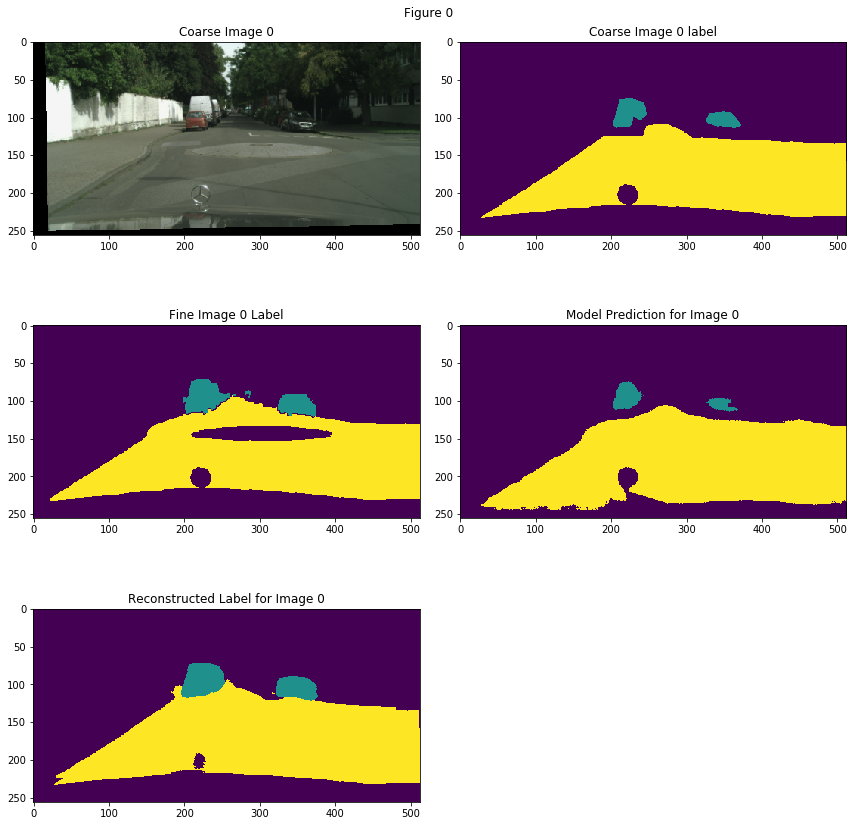

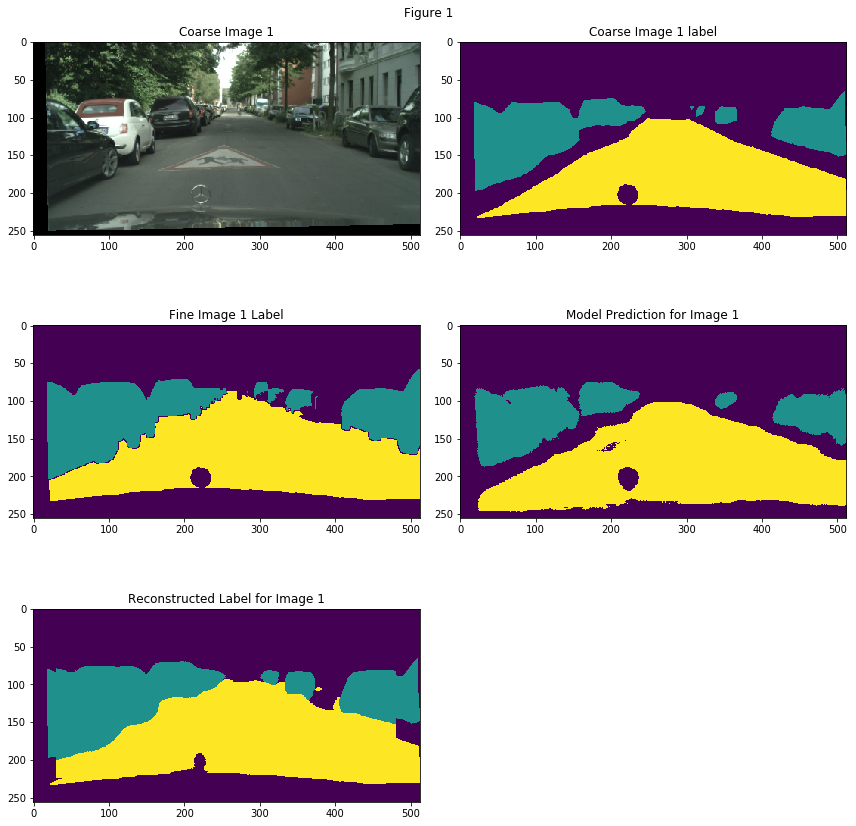

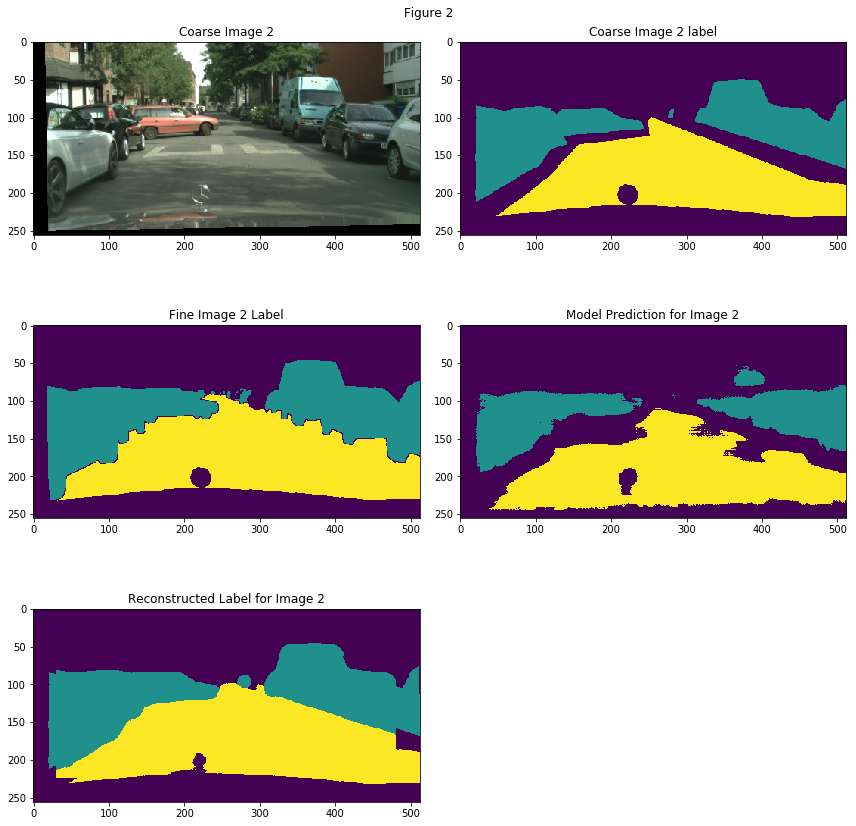

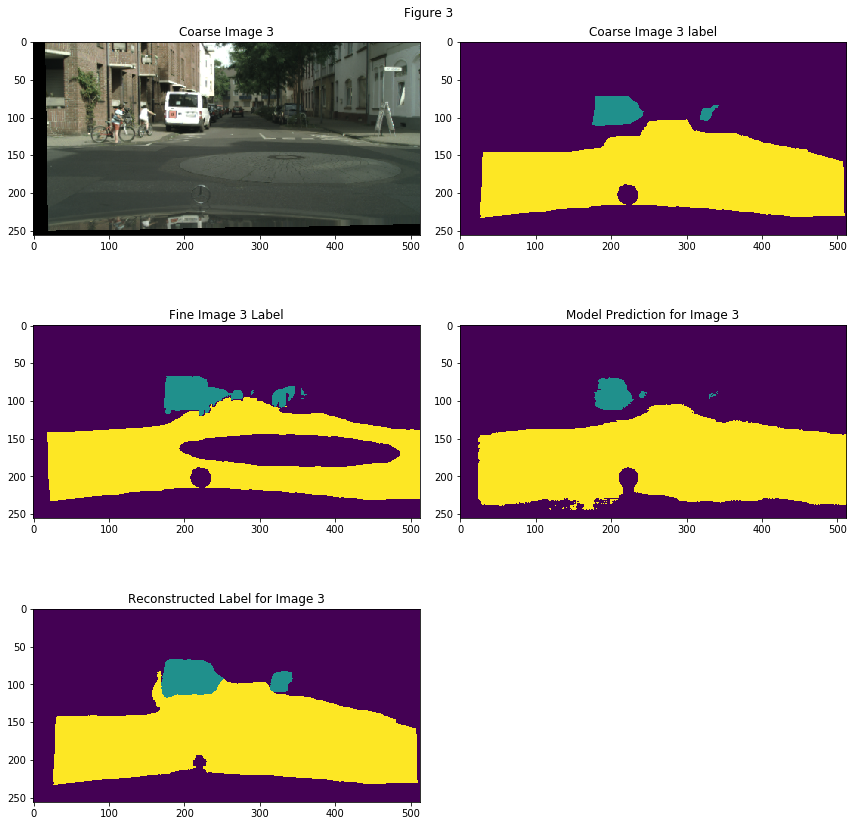

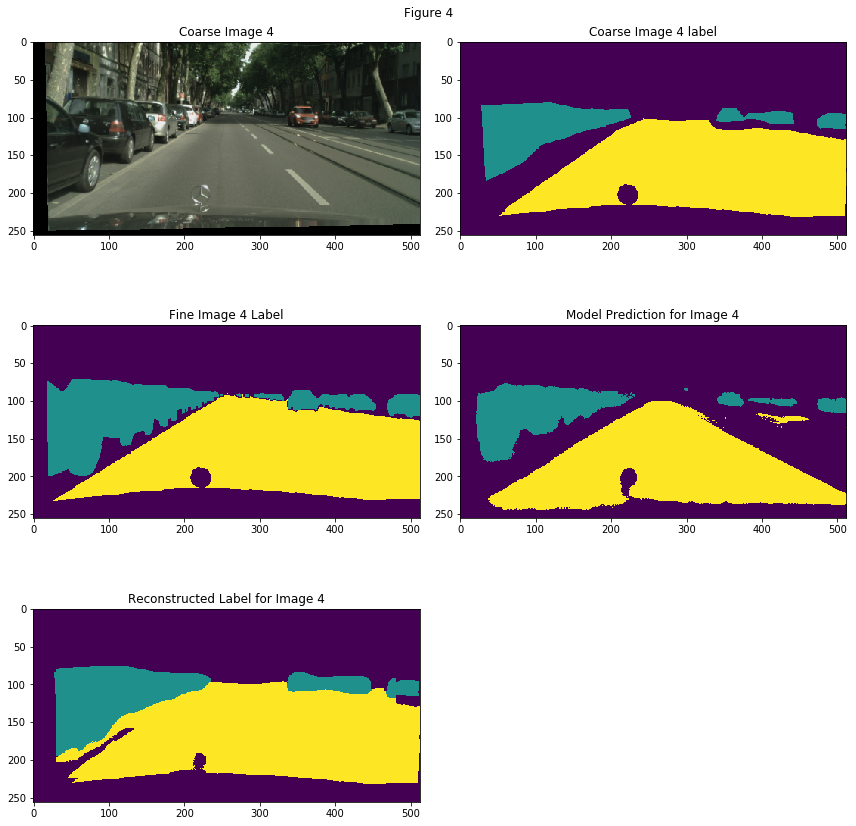

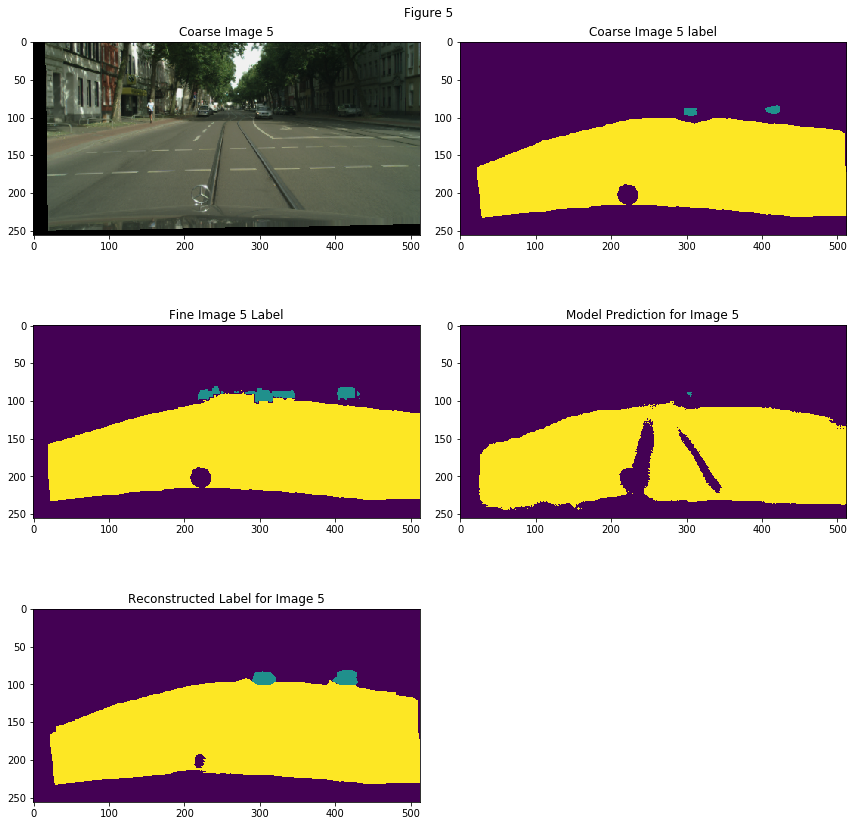

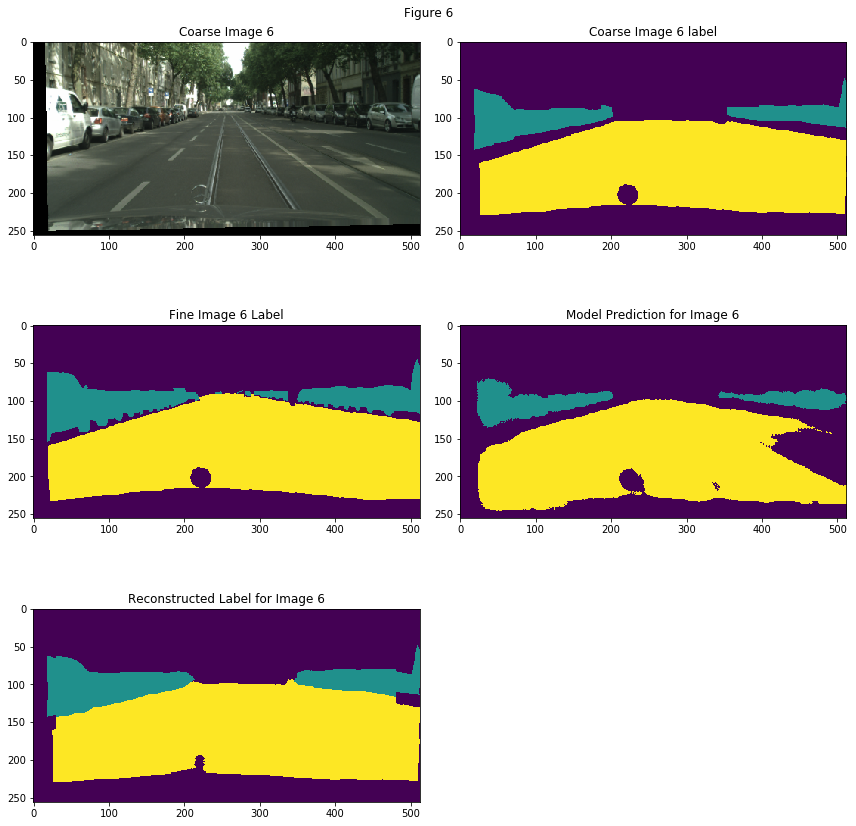

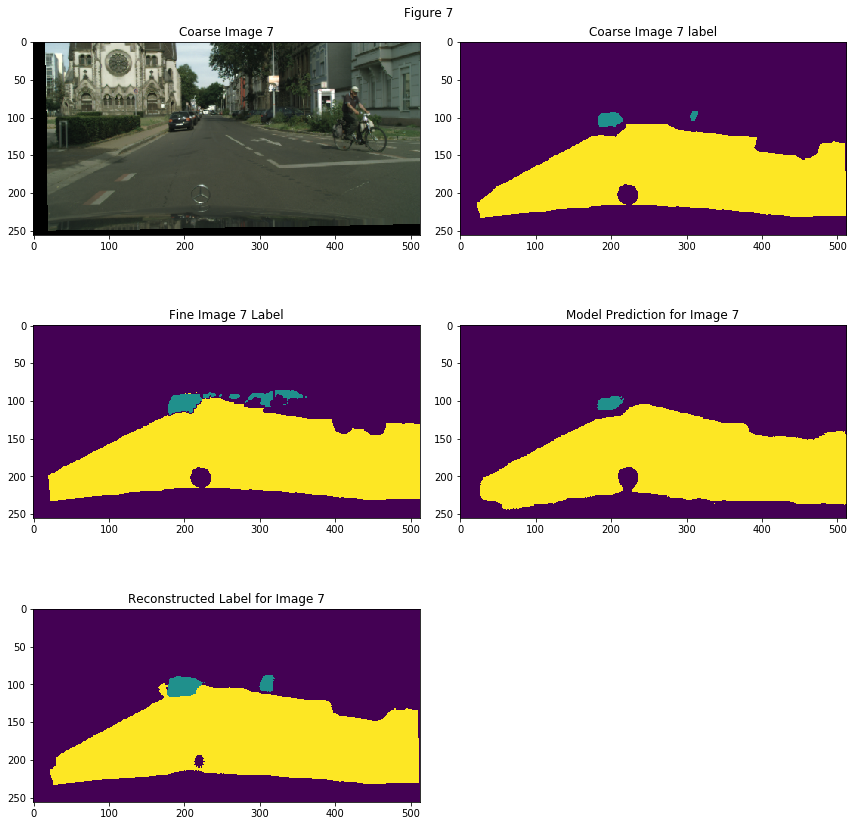

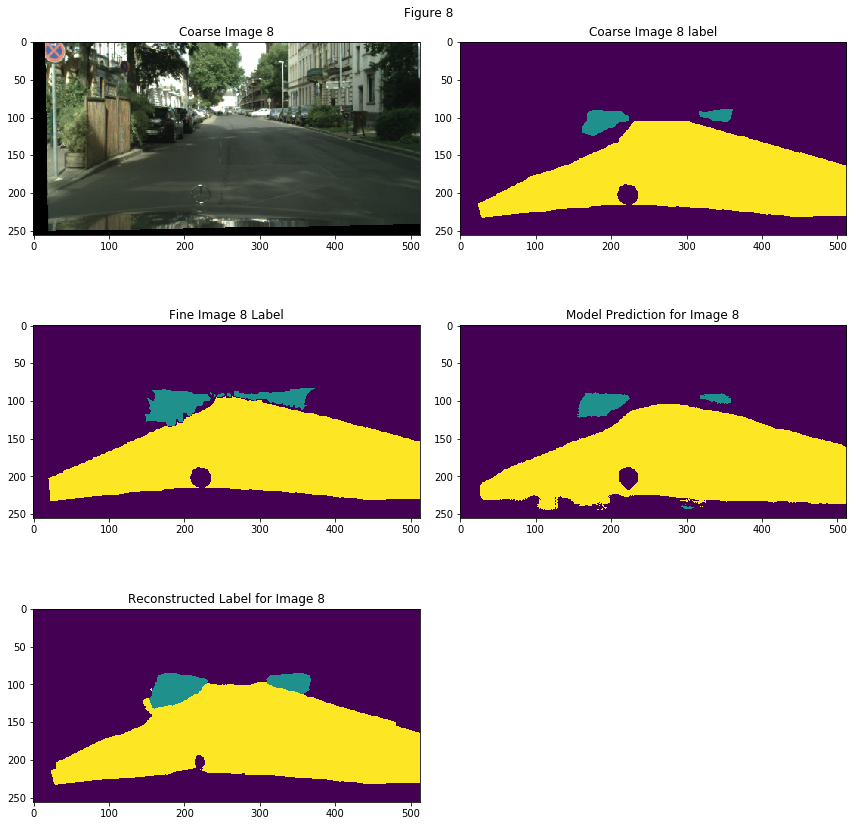

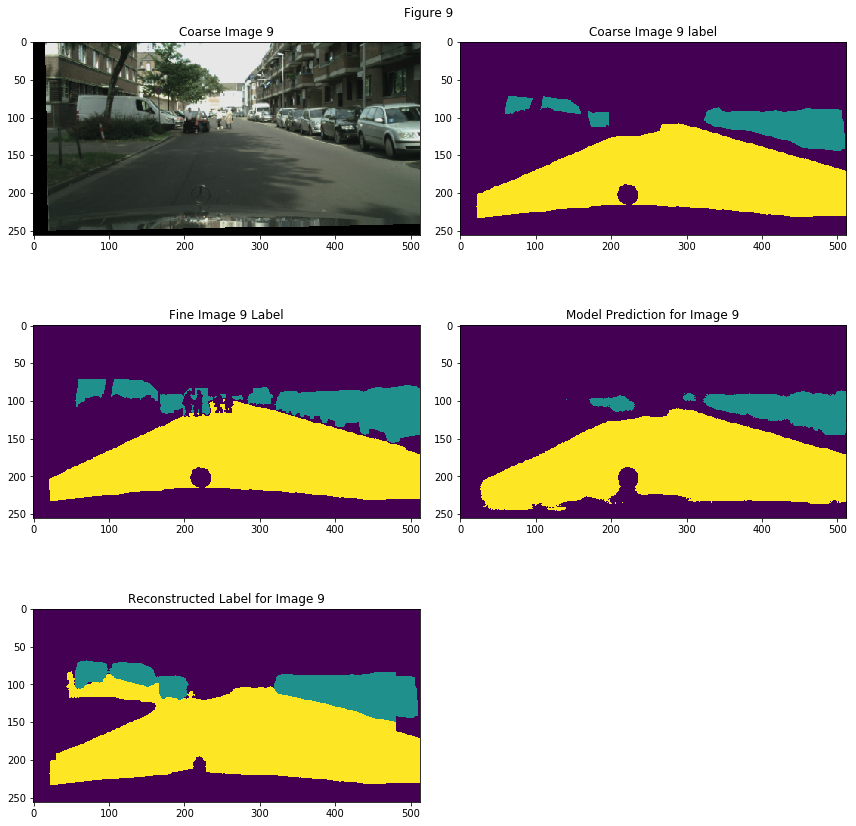

In [221]:
view_corrections_on_training_data(coarse_model, ec_model, n=10, ignore_pedestrians=ignore_pedestrians, 
                                  diff=False, use_model_pred=False, output_window_size=output_window_size, 
                                  input_window_size=input_window_size, use_x=True)

2975
2975
2975


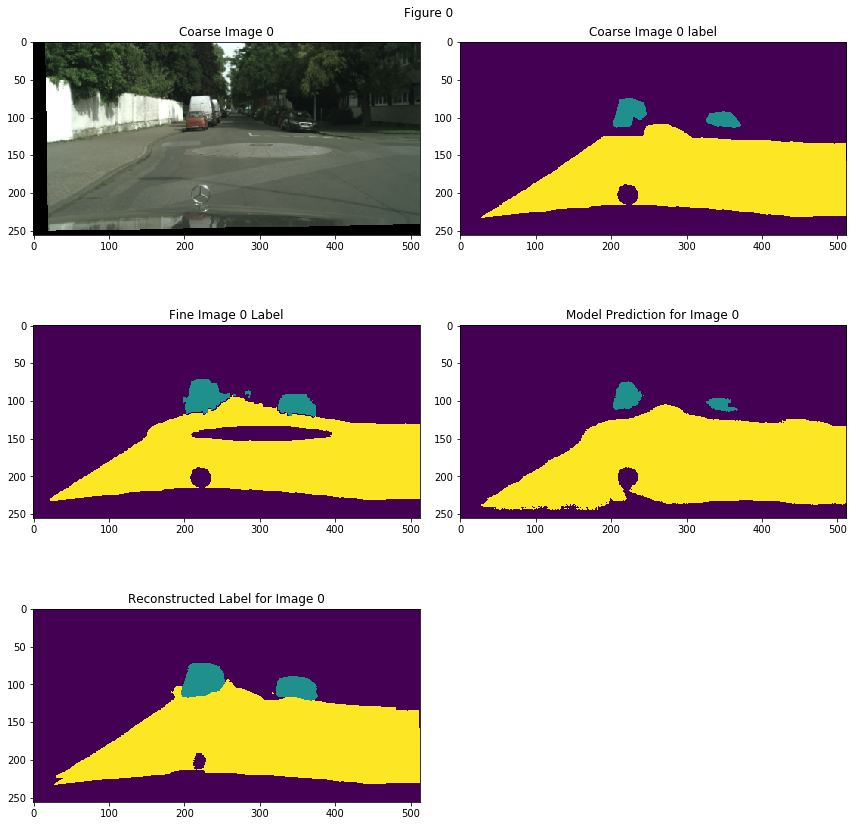

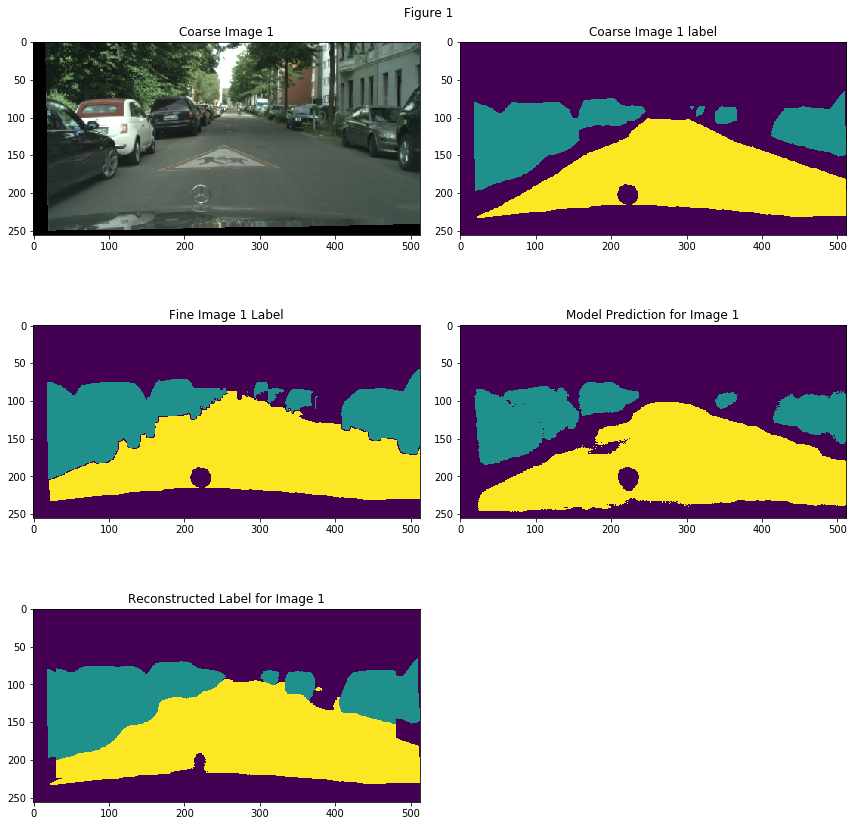

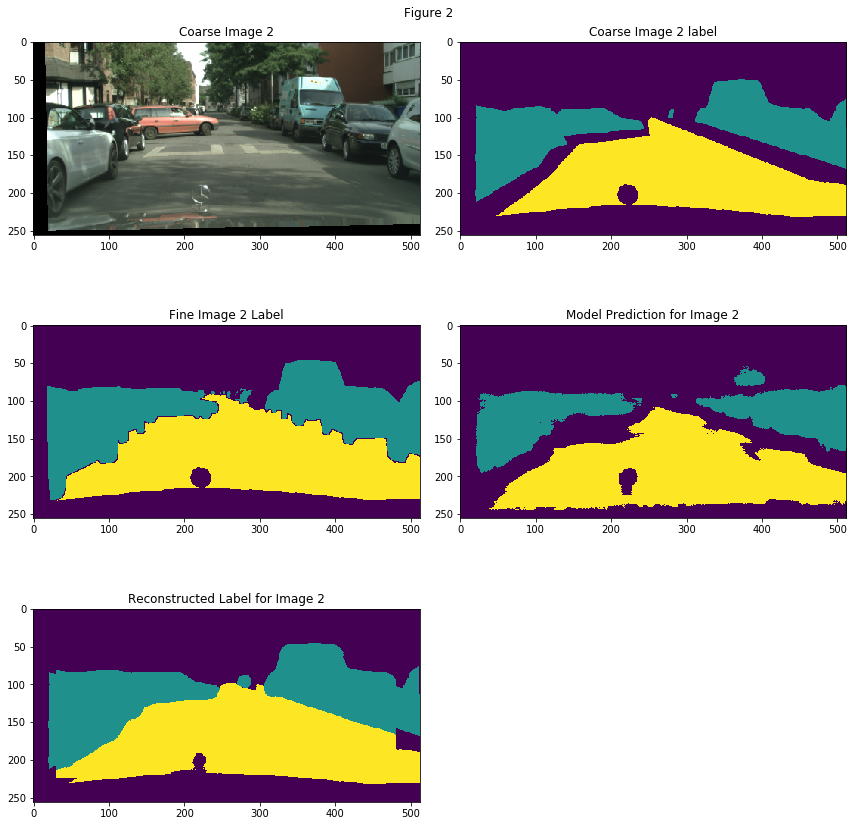

In [220]:
view_corrections_on_training_data(coarse_model, ec_model, n=3, ignore_pedestrians=ignore_pedestrians, 
                                  diff=False, use_model_pred=False, output_window_size=output_window_size, 
                                  input_window_size=input_window_size, use_x=True)

2975
2975
2975


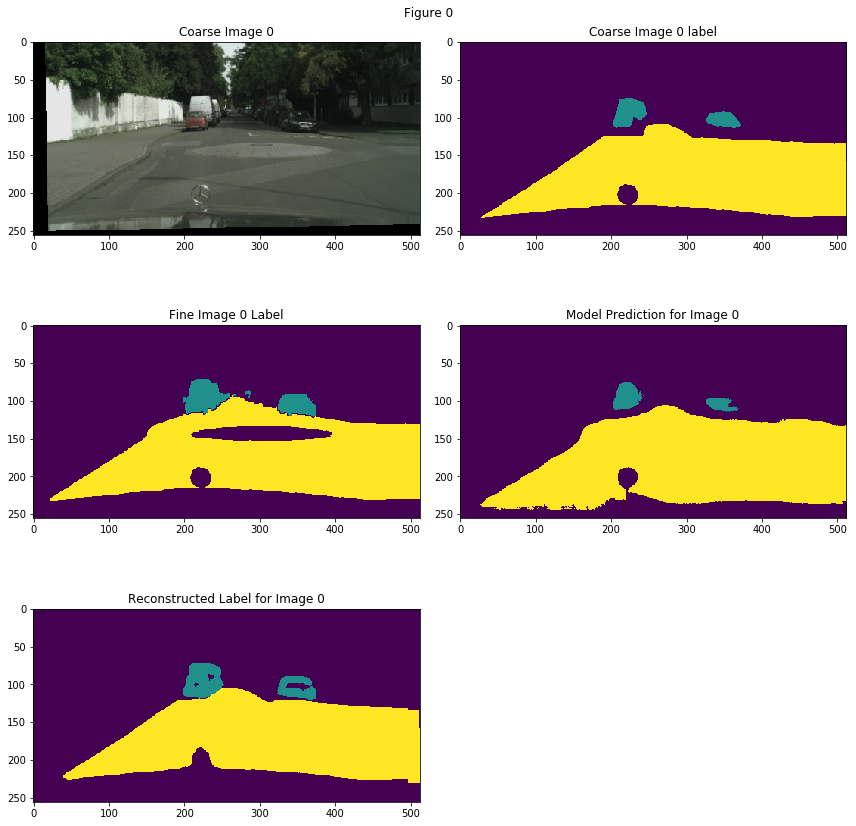

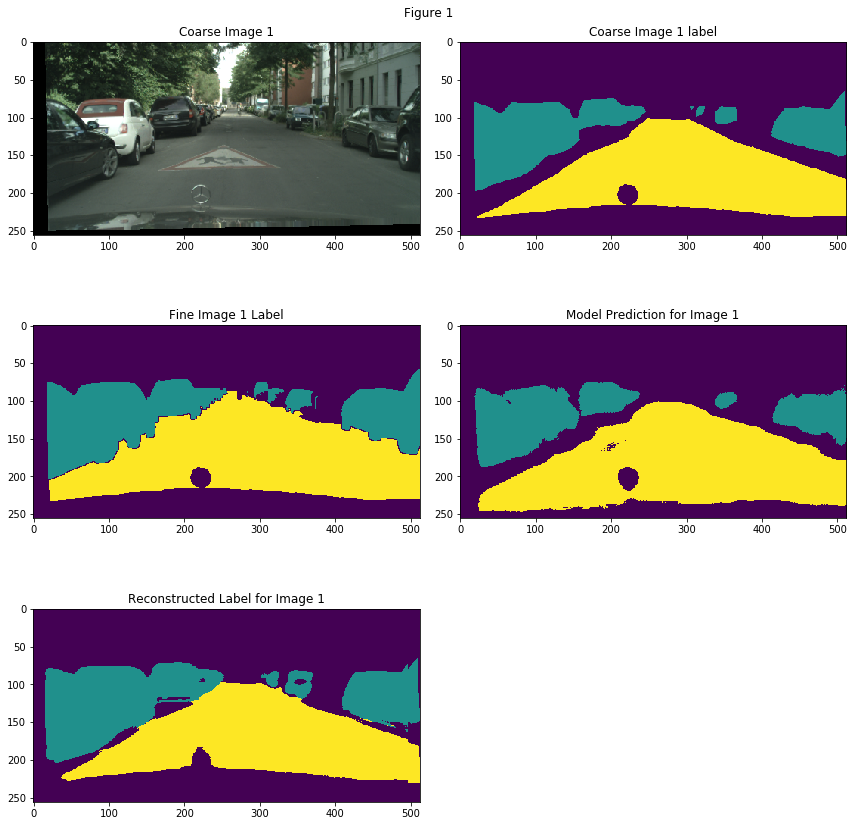

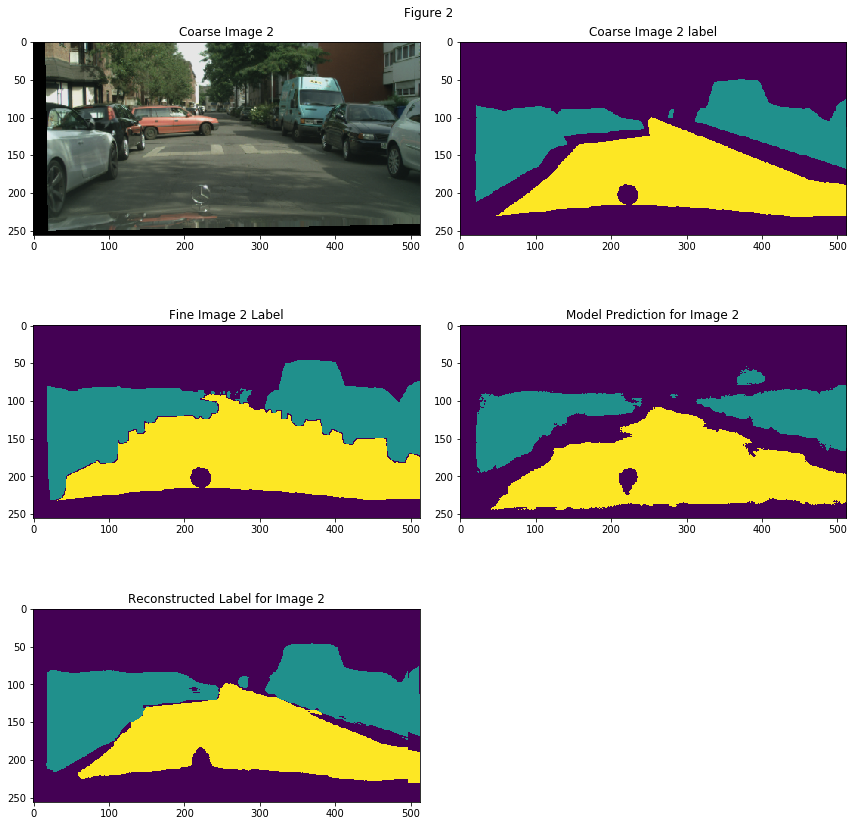

In [213]:
view_corrections_on_training_data(coarse_model, ec_model, n=3, ignore_pedestrians=ignore_pedestrians, 
                                  diff=False, use_model_pred=False, output_window_size=output_window_size, 
                                  input_window_size=input_window_size, use_x=True)

2975
2975
2975


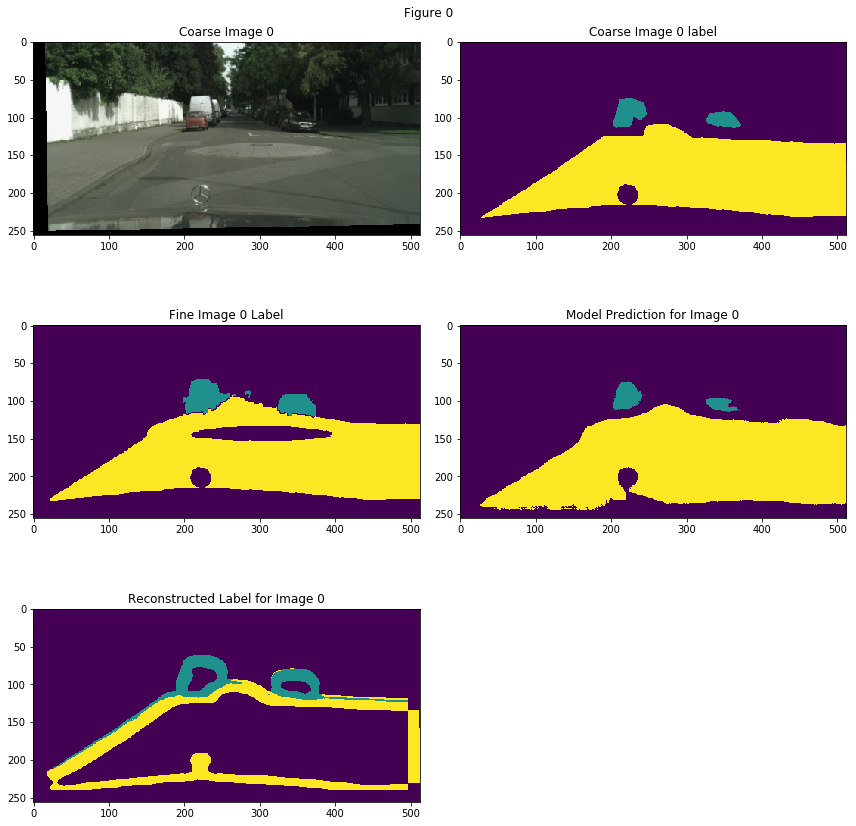

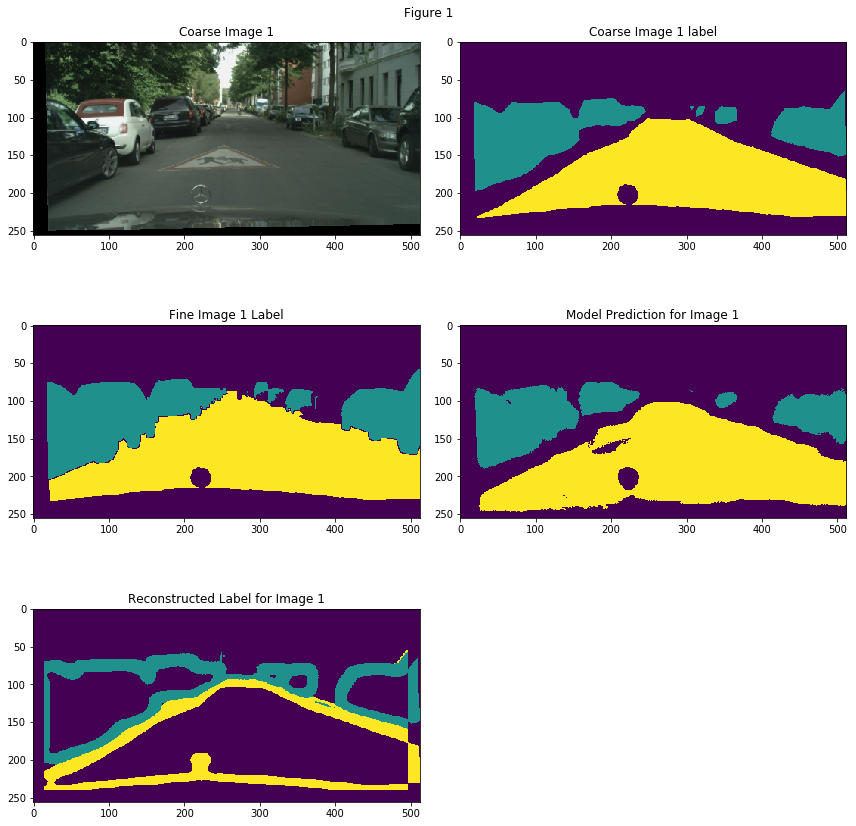

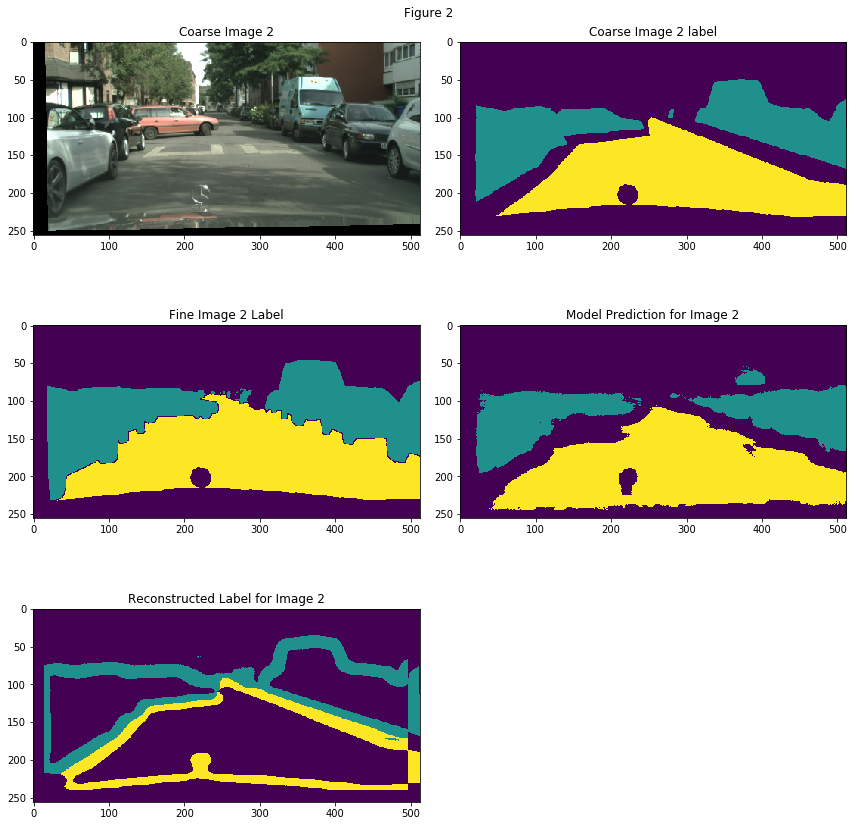

In [207]:
view_corrections_on_training_data(coarse_model, ec_model, n=3, ignore_pedestrians=ignore_pedestrians, 
                                  diff=False, use_model_pred=False, output_window_size=output_window_size, 
                                  input_window_size=input_window_size, use_x=True)

2975
2975
2975


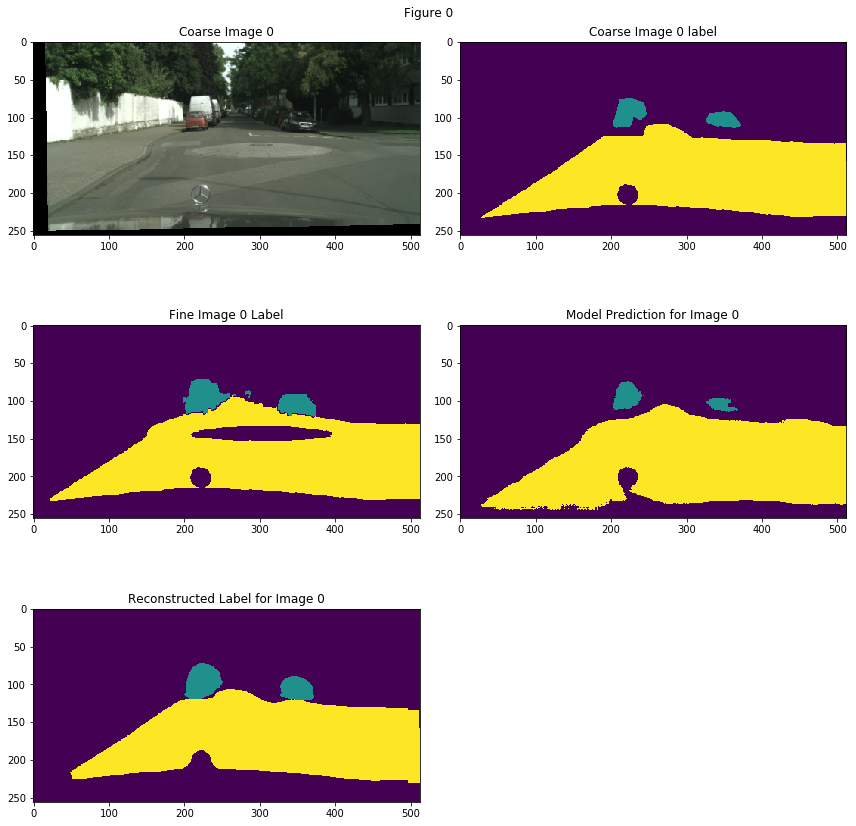

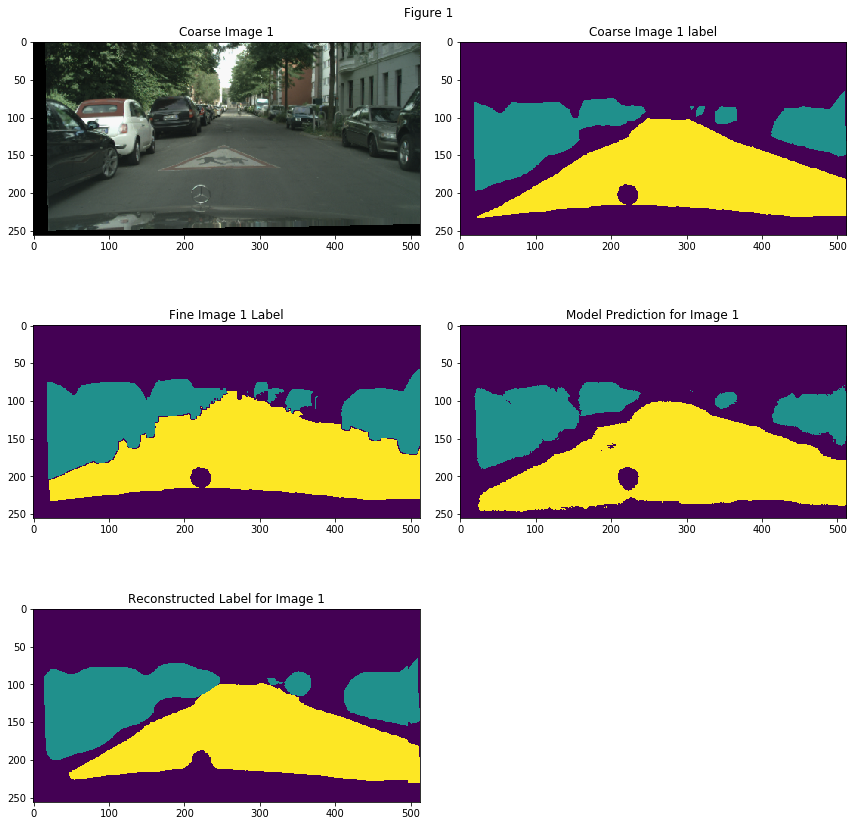

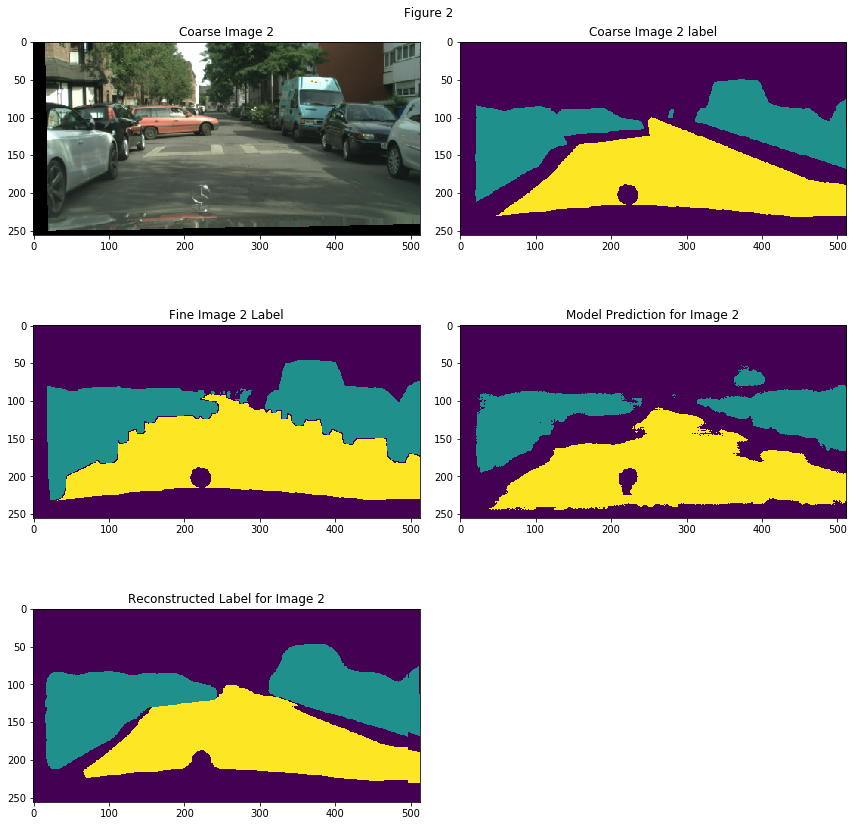

In [164]:
view_corrections_on_training_data(coarse_model, ec_model, n=3, ignore_pedestrians=ignore_pedestrians, 
                                  diff=False, use_model_pred=False, output_window_size=output_window_size, 
                                  input_window_size=input_window_size, use_x=True)

# See Corrected Data (Only Y)

2975
2975
2975


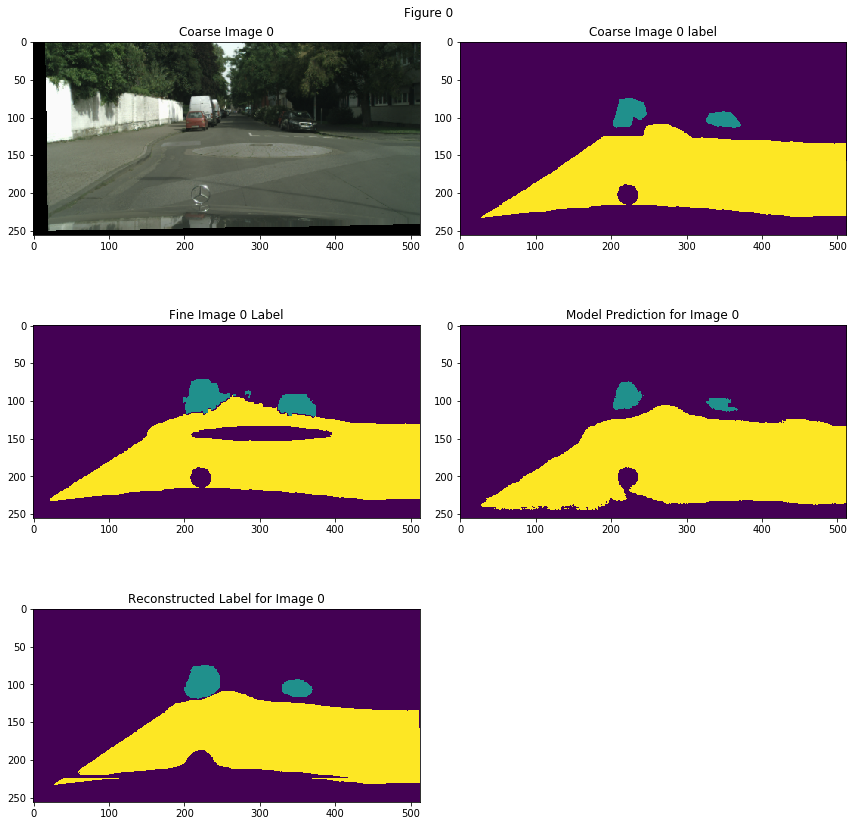

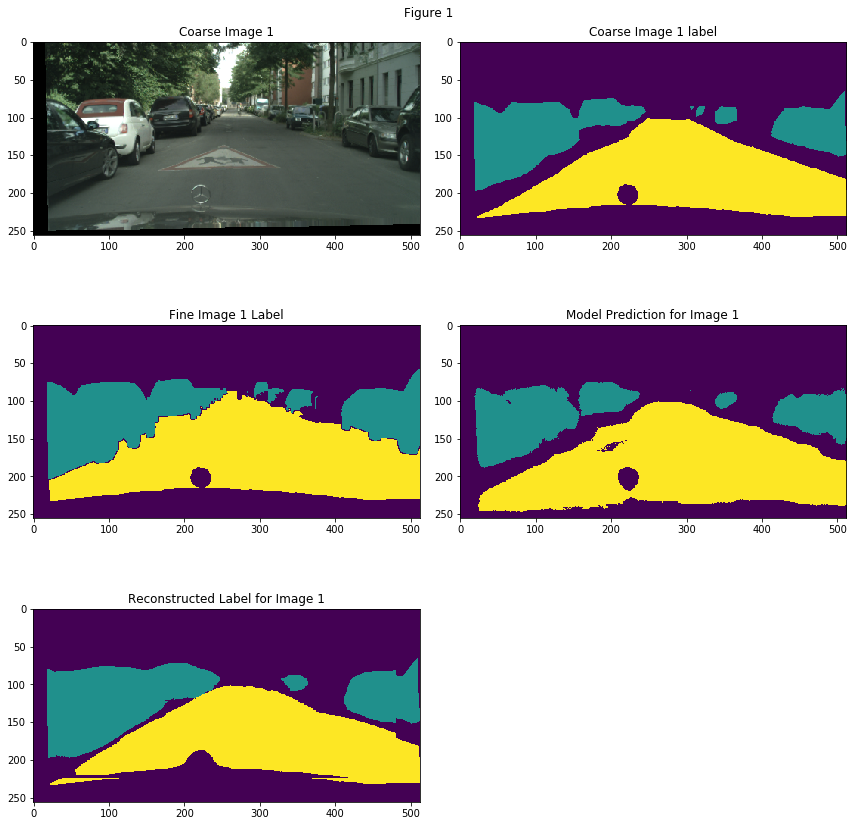

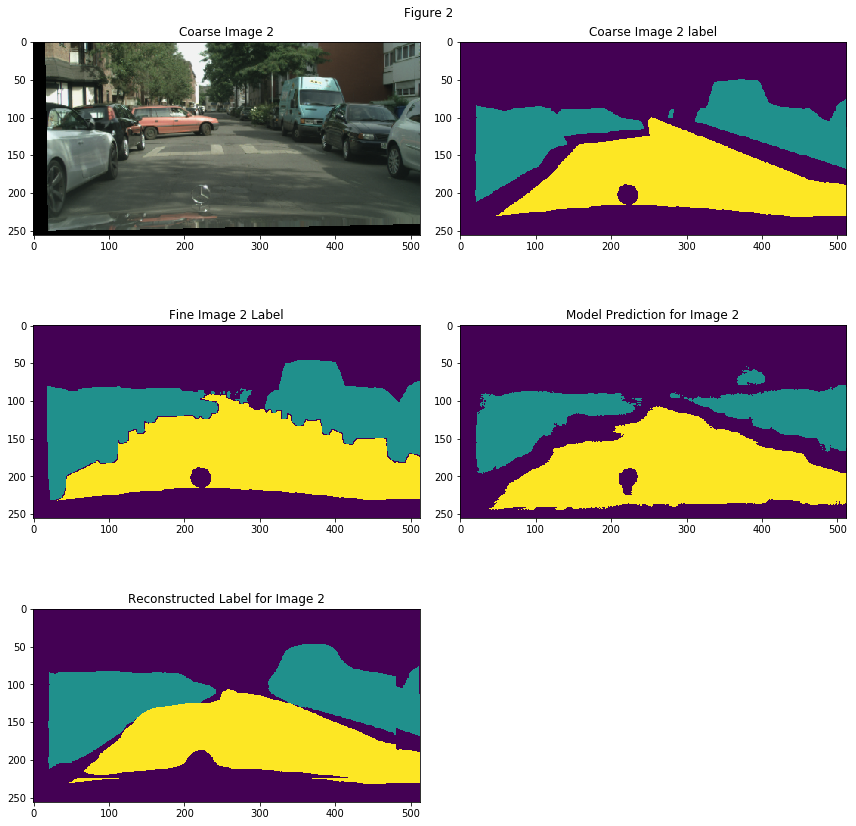

In [148]:
view_corrections_on_training_data(coarse_model, ec_model, n=3, ignore_pedestrians=ignore_pedestrians, 
                                  diff=False, use_model_pred=False, output_window_size=output_window_size, 
                                  input_window_size=input_window_size, use_x=False)